In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
from collections import Counter

from maxent_graph import ecm

We'll use a network of co-occurrences in the Game of Throne novels. Edges are weighted by the number of times two characters' names appeared within 15 words of each other in the text.

See  A. Beveridge and J. Shan, "Network of Thrones." Math Horizons 23(4), 18-22 (2016), http://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20%281%29.pdf

In [2]:
fn = "../data/game_thrones.graphml"
weight_key = "weight"

In [3]:
g = nx.read_graphml(fn)
g = nx.convert_node_labels_to_integers(g)
W = nx.adjacency_matrix(g, weight=weight_key)

Let's check the size of the graph...

In [4]:
g.number_of_nodes(), g.number_of_edges()

(107, 352)

Let's look at the most frequent co-occurrences

In [5]:
info = [(g.nodes[s]['name'], g.nodes[t]['name'], a['weight']) for s, t, a in g.edges(data=True)]

In [6]:
df = pd.DataFrame(info, columns=['Person 1', 'Person2', 'Co-occurrence'])

In [7]:
df.sort_values(by='Co-occurrence', ascending=False).head(20)

,Person 1,Person2,Co-occurrence
153,Bran,Hodor,96
27,Jaime,Brienne,88
93,Tyrion,Sansa,77
125,Mance,Jon,69
89,Tyrion,Joffrey,54
219,Jon,Ygritte,54
157,Bran,Meera,54
16,Samwell,Jon,52
329,Daenerys,Jorah,47
154,Bran,Jojen,46


(array([178.,  53.,  28.,  25.,  14.,   7.,   6.,   7.,   7.,   4.,   6.,
          1.,   4.,   3.,   1.,   1.,   3.,   0.,   0.,   0.,   0.,   1.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([ 4.        ,  7.06666667, 10.13333333, 13.2       , 16.26666667,
        19.33333333, 22.4       , 25.46666667, 28.53333333, 31.6       ,
        34.66666667, 37.73333333, 40.8       , 43.86666667, 46.93333333,
        50.        , 53.06666667, 56.13333333, 59.2       , 62.26666667,
        65.33333333, 68.4       , 71.46666667, 74.53333333, 77.6       ,
        80.66666667, 83.73333333, 86.8       , 89.86666667, 92.93333333,
        96.        ]),
 <BarContainer object of 30 artists>)

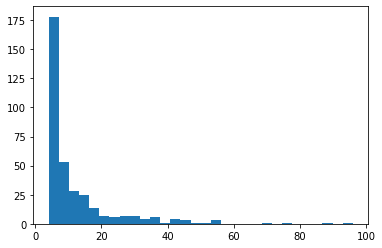

In [8]:
plt.hist(df['Co-occurrence'].values, bins=30)

In [9]:
labels = {n: a['name'] for n, a in g.nodes(data=True)}

In [10]:
strengths = list(dict(g.degree(weight='weight')).values())

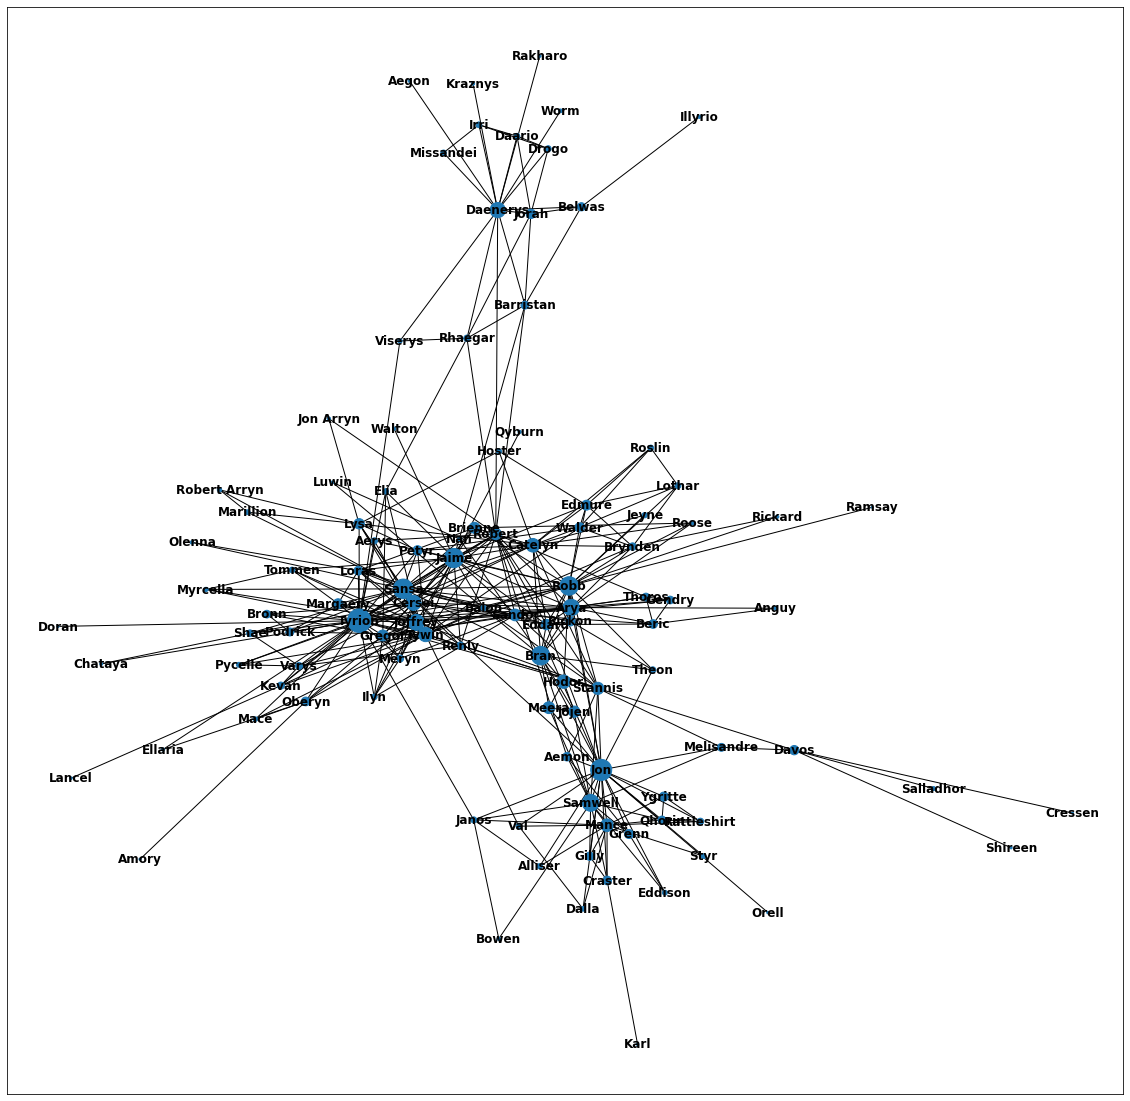

In [11]:
plt.figure(figsize=(20,20)) 
nx.draw_networkx(g, node_size = strengths, labels=labels, font_weight='semibold')

Now let's try filtering with the Enhanced Configuration Model

In [12]:
model = ecm.ECM(W)
initial_guess = model.get_initial_guess()
solution = model.solve(initial_guess, verbose=True)

/home/deklan/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Took 2.311742067337036 seconds
Relative error for expected degree/strength sequence: 

Percentile      Relative error
------------  ----------------
Min                1.31946e-09
25th               1.69064e-07
Median             3.82413e-07
75th               8.74395e-07
Max                0.0785169

Residual error: 13.976015126302375


In [13]:
pval_M = model.get_pval_matrix(solution.x, W)

In [14]:
pval_M

<107x107 sparse matrix of type '<class 'numpy.float64'>'
	with 704 stored elements in List of Lists format>

In [15]:
lower_pval_M = scipy.sparse.tril(pval_M).toarray()

(array([89., 61., 42., 29., 21., 17.,  9.,  9., 13.,  8., 13.,  4.,  6.,
         2.,  7.,  5.,  3.,  3.,  2.,  0.,  4.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  1.]),
 array([0.0019308 , 0.02367953, 0.04542826, 0.06717699, 0.08892573,
        0.11067446, 0.13242319, 0.15417192, 0.17592066, 0.19766939,
        0.21941812, 0.24116685, 0.26291559, 0.28466432, 0.30641305,
        0.32816179, 0.34991052, 0.37165925, 0.39340798, 0.41515672,
        0.43690545, 0.45865418, 0.48040291, 0.50215165, 0.52390038,
        0.54564911, 0.56739784, 0.58914658, 0.61089531, 0.63264404,
        0.65439277]),
 <BarContainer object of 30 artists>)

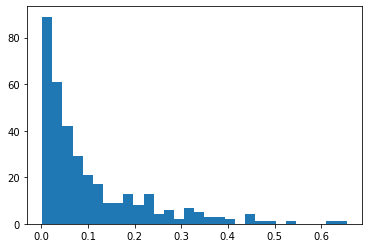

In [16]:
plt.hist(lower_pval_M[lower_pval_M.nonzero()], bins=30)

In [17]:
to_add = []

for (i,j) in zip(*lower_pval_M.nonzero()):
    p = lower_pval_M[i,j]
    g[i][j]['Surprise'] = -np.log(p)

In [23]:
info = []

for s, t, a in g.edges(data=True):
    person1_name = g.nodes[s]['name']
    person2_name = g.nodes[t]['name']
    cooccurrence = a['weight']
    surprise = a['Surprise']
    
    info.append({
        'Person 1': g.nodes[s]['name'],
        'Person 1 Degree': g.degree()[s],
        'Person 1 Strength': g.degree(weight='weight')[s],
        'Person 2': g.nodes[t]['name'],
        'Person 2 Degree': g.degree()[t],
        'Person 2 Strength': g.degree(weight='weight')[t],
        'Co-occurrence': a['weight'],
        'Surprise': a['Surprise']
    })

In [24]:
df = pd.DataFrame(info)

Lot of minor characters with low strength and degree. Let's filter those a bit

In [53]:
df.query('`Person 1 Degree` > 3 & `Person 2 Degree` > 3').sort_values(by='Surprise', ascending=False).head(20)

,Person 1,Person 1 Degree,Person 1 Strength,Person 2,Person 2 Degree,Person 2 Strength,Co-occurrence,Surprise
27,Jaime,24,372,Brienne,7,122,88,5.204790
340,Davos,5,87,Melisandre,4,62,30,5.119521
281,Edmure,8,98,Roslin,4,32,16,5.115101
259,Bronn,4,59,Podrick,5,64,19,4.989155
150,Beric,6,75,Thoros,5,60,21,4.987861
243,Belwas,4,67,Barristan,6,63,18,4.912581
287,Lysa,10,108,Petyr,7,89,29,4.898132
323,Drogo,4,35,Irri,4,33,7,4.836373
143,Arya,19,269,Sandor,13,137,46,4.787311
130,Oberyn,7,76,Gregor,12,117,24,4.715182


Filtering with p-value of 0.10

In [39]:
def filter_edge(n1, n2):
    return g[n1][n2]['Surprise'] > -np.log(0.10)

subgraph = nx.subgraph_view(g, filter_edge=filter_edge)

In [40]:
subgraph.number_of_nodes(), subgraph.number_of_edges()

(107, 233)

Edges reduced from 352 to 233

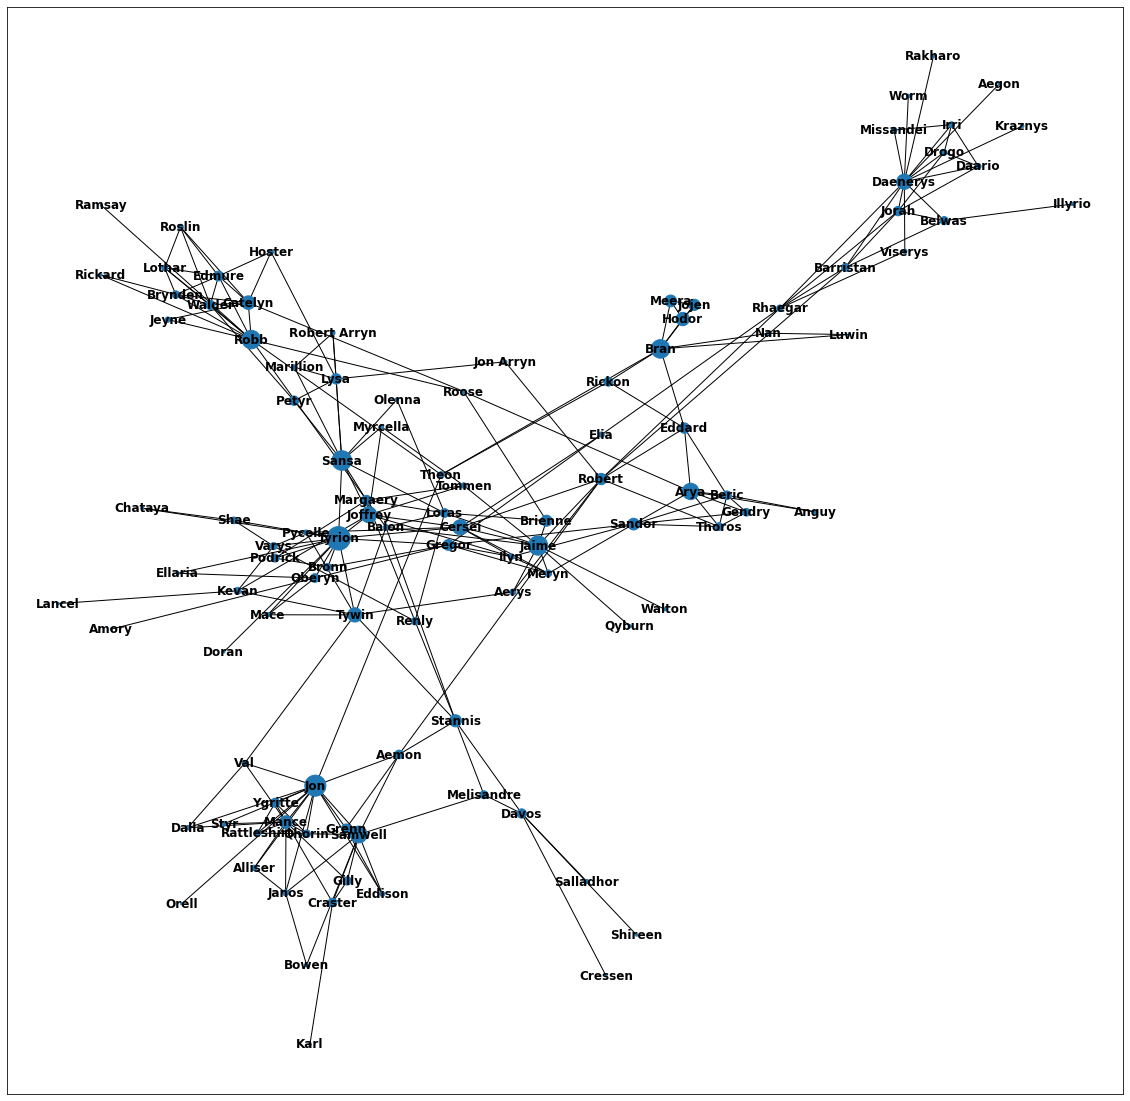

In [51]:
plt.figure(figsize=(20,20)) 
nx.draw_networkx(subgraph, node_size = strengths, labels=labels, font_weight='semibold')

Better!